In [15]:
from vec_pot import *
from magpi.prelude import *
from magpi.calc import divergence, curl, laplace
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton, Sobol
from magpi.integrate import gauss, simpson, QuadRule
from matplotlib.ticker import FormatStrFormatter
import numpy as np

jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", False)
#jax.config.update("jax_enable_x64", True)
%matplotlib widget

key = random.PRNGKey(42)

In [16]:
def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


In [17]:
mu0 = 4*pi*10**-7  # Tm/A
Js = 1.61  # T
Ms = Js / mu0  # A/m
Km = mu0 * Ms**2  # J/m3
L = 70.0  # nm
Ka = 4.3e6 / Km  # -
easy_axis = unit_vec(array([0., 0., 1.]))
A = 7.3e-12 / Km * 1e18 / L ** 2 # 1/nm2
dh = 5e-3
hext = jnp.arange(-3.5, 1., dh)[::-1]  # -
hext_axis = unit_vec(array([1., 0., 10.]))
m0 = lambda x: zeros_like(x).at[..., -1].set(1.)

domain = Cuboid(
    linspace(-0.5, 0.5, 5),
    linspace(-0.5, 0.5, 5),
    linspace(-0.5, 0.5, 5)
)

X = array(Halton(3, seed=42).random(2**12))
X = domain.transform(X)

Z = lax.map(
    lambda x: surface_tensors(x, domain, 5, gauss(9)), 
    X
)

grad_Z = lax.map(
    lambda x: surface_tensors_grad(x, domain, 5, gauss(9)), 
    X
)

X_val = array(Halton(3, seed=144).random(2**12))
X_val = domain.transform(X_val)

Z_val = lax.map(
    lambda x: surface_tensors(x, domain, 5, gauss(9)), 
    X_val
)

grad_Z_val = lax.map(
    lambda x: surface_tensors_grad(x, domain, 5, gauss(9)), 
    X_val
)


In [18]:
class VecPotential(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 10
        activation = tanh
        x = domain.normalize(x)
        u = activation(nn.Dense(nodes, name="transformer1")(x))
        v = activation(nn.Dense(nodes, name="transformer2")(x))
        h = activation(nn.Dense(nodes, name="dense1")(x))
        z = activation(nn.Dense(nodes, name="dense2")(h))
        h = (1 - z) * u + z * v
        # z = activation(nn.Dense(nodes, name="dense3")(h))
        # h = (1 - z) * u + z * v
        y = nn.Dense(3, name="dense4")(h)
        return y


key, _k = random.split(key)
A1_model = VecPotential()
vec_pot_params_init = A1_model.init(_k, zeros((3,)))
#vec_pot_params_init = tree_map(lambda p: p.astype(jnp.float64), vec_pot_params_init)

def A1(x, params):
    return A1_model.apply(params, x)


class PINN(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 10
        activation = nn.tanh
        x = domain.normalize(x)
        u = activation(nn.Dense(nodes, name="transformer1")(x))
        v = activation(nn.Dense(nodes, name="transformer2")(x))
        h = activation(nn.Dense(nodes, name="dense1")(x))
        z = activation(nn.Dense(nodes, name="dense2")(h))
        h = (1 - z) * u + z * v
        # z = activation(nn.Dense(nodes, name="dense3")(h))
        # h = (1 - z) * u + z * v
        y = nn.Dense(3, name="dense4")(h)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)))

    
def mag(mag0, x, params):
    x = domain.normalize(x)
    p = mag_pinn_model.apply(params, x)
    m = mag0(x)
    return cayley_rotation(p, m)

def exchange_energy(m, x):
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        return 1 - (m(x) @ easy_axis) ** 2

    return Ka * mean(vmap(e_ani)(x))


def ext_energy(m, x, hext):
    def e_ext(x):
        return m(x) @ hext
    
    return - mean(vmap(e_ext)(x))


def mag_energy(
    domain: Cuboid,
    A1: Callable[..., Array],
    m: Callable[..., Array],
    X_Z_grad_Z: tuple[Array, ChargeTensor, GradTargetTensor],
    args_A1: tuple = (),
    args_m: tuple = (),
    stop_gradient: bool = True,
) -> Scalar:
    X, Z, grad_Z = X_Z_grad_Z
    lA1 = lambda x: domain.adf(x) * A1(x, *args_A1)

    def e_dom(x, z, grad_z):
        JA1 = jacfwd(lA1)(x)
        curl_A1 = curl(lA1)(x)
        A2, curl_A2, JA2 = solve_A2(domain, A1, m, args_A1, args_m)(z, grad_z)
        if stop_gradient:
            curl_A1 = lax.stop_gradient(curl_A1)
            curl_A2 = lax.stop_gradient(curl_A2)
            A2 = lax.stop_gradient(A2)
            JA2 = lax.stop_gradient(JA2)
        es1 = norm(m(x)) ** 2 + jnp.sum(JA1 * JA1)
        es2 = (- 2 * dot(m(x), curl_A1 + curl_A2)
            - curl(m)(x) @ A2
            + m(x) @ curl_A2
            - laplace(lA1)(x) @ A2
            - jnp.sum(JA1 * JA2)
        )
        return 1 / 2 * es1, 1 / 2 * es2

    return tree_map(mean, vmap(e_dom)(X, Z, grad_Z))


@jit
def loss_m(params_m, params_A1, hext):
    m = lambda x: mag(m0, x, params_m)
    e_ex = exchange_energy(m, X)
    e_ani = ani_energy(m, X)
    e_ext = ext_energy(m, X, hext * hext_axis)
    es1, es2 = mag_energy(domain, A1, m, (X, Z, grad_Z), args_A1=(params_A1,), args_m=())
    e_mag = es1 + es2
    l = e_ex + e_ani + e_ext + es1 + 2 * es2
    return l, {
        'e_tot': e_ex + e_ani + e_mag + e_ext,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
        'e_ext': e_ext
    }
    
@jit
def loss_A1(params_A1, params_m, hext):
    m = lambda x: mag(m0, x, params_m)
    lA1 = lambda x: domain.adf(x) * A1(x, params_A1)
    def loss(x):
        return norm(laplace(lA1)(x) + curl(m)(x)) ** 2
    return mean(vmap(loss)(X))




In [19]:
from typing import NamedTuple
from dataclasses import dataclass
from jaxopt.base import IterativeSolver, OptStep
import chex

class State(NamedTuple):
    state_opt1: NamedTuple
    state_opt2: NamedTuple
    
    @property
    def iter_num(self):
        return jnp.maximum(self.state_opt1.iter_num, self.state_opt2.iter_num)
    
    

@dataclass(eq=False)
class AlternatingSolver(IterativeSolver):
    opt1: IterativeSolver
    opt2: IterativeSolver
    maxiter: int = 100
    itersteps_opt1: int = 1
    itersteps_opt2: int = 1
    jit: bool = True
    unroll: bool = False
    verbose: bool = False
    implicit_diff: bool = True
    implicit_diff_solve: Optional[Callable] = None
    
    def init_state(self, init_params: chex.ArrayTree, *args, **kwargs):
        if isinstance(init_params, OptStep):
            state = init_params.state
            init_params = init_params.params
            params1, params2 = init_params
            init_params1 = OptStep(params1, state.state_opt1)
            init_params2 = OptStep(params2, state.state_opt2)
        else:
            init_params1, init_params2 = init_params
            params1, params2 = init_params
        
        state_opt1 = self.opt1.init_state(init_params1, params2, *args, **kwargs)
        state_opt2 = self.opt2.init_state(init_params2, params1, *args, **kwargs)

        return State(
            state_opt1=state_opt1,
            state_opt2=state_opt2
        )
        
    def update(self, params, state, *args, **kwargs) -> OptStep:
        if isinstance(params, OptStep):
            #state = params.state
            params = params.params
            
        
        params1, params2 = params
        #state_opt1, state_opt2 = state.state_opt1, state.state_opt2
        def _iter1(i, step):
            return self.opt1.update(step.params, step.state, params2, *args, **kwargs)
        
        step1 = lax.fori_loop(0, self.itersteps_opt1, _iter1, OptStep(params1, state.state_opt1))
        
        def _iter2(i, step):
            return self.opt2.update(step.params, step.state, step1.params, *args, **kwargs)
        
        step2 = lax.fori_loop(0, self.itersteps_opt2, _iter2, OptStep(params2, state.state_opt2))
        #step1 = self.opt1.update(params1, state_opt1, params2, *args, **kwargs)
        #step2 = self.opt2.update(params2, state_opt2, step1.params, *args, **kwargs)
        state = State(
            state_opt1=step1.state,
            state_opt2=step2.state
        )
        return OptStep(
            (step1.params, step2.params), state
        )
        
    def optimality_fun(self, params, *args, **kwargs):
        params1, params2 = params
        e1 = self.opt1.optimality_fun(params1, params2, *args, **kwargs)
        e2 = self.opt2.optimality_fun(params2, params1, *args, **kwargs)
        return (e1, e2)
    
    def _cond_fun(self, inputs):
        _, state = inputs[0]
        return (state.state_opt1.error > self.opt1.tol) | (state.state_opt2.error > self.opt2.tol)

In [44]:
import time
from magpi.opt import TR
from jaxopt import LBFGS
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        return result, te-ts
    return wrap

def train(params,
          maxiter=50,
          tol_A1=0.01,
          tol_m=0.05,
          init_tr_radius=0.1,
          max_tr_radius=1.,
          min_tr_radius=1e-8,
          itersteps1=1,
          itersteps2=1):
    @jit
    def mean_mag(params_m):
        m = lambda x: mag(m0, x, params_m)
        def m_proj(x):
            return m(x) @ hext_axis
        return mean(vmap(m_proj)(X_val))
        
    def cb(step):
        state = step.state
        h = dict(
            loss=state.value,
            error=state.error,
            aux=state.aux,
            rho=state.rho,
            tr_radius=state.tr_radius,
            steihaug_curvature=state.steihaug_curvature,
        )
        hist.append(h)

    def init(params, hext, maxiter):   
        solver_A1 = LBFGS(loss_A1, tol=tol_A1, history_size=20, jit=False)
        solver_m = TR(loss_m, has_aux=True, tol=tol_m, init_tr_radius=init_tr_radius,
                 max_tr_radius=max_tr_radius, min_tr_radius=min_tr_radius, callback=cb, unroll=False, jit=False)
        opt = AlternatingSolver(solver_A1, solver_m, maxiter=maxiter, itersteps_opt1=itersteps1, itersteps_opt2=itersteps2, unroll=False, jit=False)

        _state = opt.init_state(params, hext)
        opt_step = OptStep(params, _state)
        return update(opt_step, hext, maxiter)
    
    @jit
    def update(opt_step, hext, maxiter):
        solver_A1 = LBFGS(loss_A1, tol=tol_A1, history_size=20)
        solver_m = TR(loss_m, has_aux=True, tol=tol_m, init_tr_radius=init_tr_radius,
                 max_tr_radius=max_tr_radius, min_tr_radius=min_tr_radius, callback=cb, unroll=False)
        opt = AlternatingSolver(solver_A1, solver_m, maxiter=maxiter, itersteps_opt1=itersteps1, itersteps_opt2=itersteps2, unroll=False, jit=True)
        
        return opt.run(opt_step, hext)
    
    hist = []
    opt_step, elapsed_time = timing(init)(params, hext[0], maxiter * 10)
    print(f"initialized in {elapsed_time}s")
    params, state = opt_step
    
    states = [state]
    mean_mags = [mean_mag(params[1])]
    histories = [hist]
    for _hext in hext[1:]:
        hist = []
        opt_step, elapsed_time = timing(update)(opt_step, _hext, maxiter)
        params, state = opt_step
        states.append(state)
        _mean_mag = mean_mag(params[1])
        e_s = state.state_opt2.aux["e_mag"]
        print(f"mean mag for {_hext:.04f}: {_mean_mag:.04f}, time: {elapsed_time:.01f}s, e_s: {e_s:.05f}")
        mean_mags.append(mean_mag(params[1]))
        histories.append(hist)
    
    return {
        'params': params,
        'mean_mags': mean_mags,
        'hist': histories,
        'states': states
    }

In [45]:
init_params = (vec_pot_params_init, pinn_params_init)
result = train(init_params, maxiter=150, init_tr_radius=0.2, max_tr_radius=1.0, itersteps1=30)

In [43]:
[(i, s.state_opt2.steihaug_curvature) for i, s in enumerate(result["states"])]

[(0, Array(0.06141622, dtype=float32)),
 (1, Array(0.07025073, dtype=float32)),
 (2, Array(0.07231402, dtype=float32)),
 (3, Array(0.07124583, dtype=float32)),
 (4, Array(0.07070096, dtype=float32)),
 (5, Array(0.07092032, dtype=float32)),
 (6, Array(0.07084969, dtype=float32)),
 (7, Array(0.06895112, dtype=float32)),
 (8, Array(0.06872775, dtype=float32)),
 (9, Array(0.06882837, dtype=float32)),
 (10, Array(0.0696481, dtype=float32)),
 (11, Array(0.07019567, dtype=float32)),
 (12, Array(0.06923202, dtype=float32)),
 (13, Array(0.07016721, dtype=float32)),
 (14, Array(0.07002009, dtype=float32)),
 (15, Array(0.06921314, dtype=float32)),
 (16, Array(0.06995182, dtype=float32)),
 (17, Array(0.06908358, dtype=float32)),
 (18, Array(0.07139259, dtype=float32)),
 (19, Array(0.07011019, dtype=float32)),
 (20, Array(0.07019541, dtype=float32)),
 (21, Array(0.07043676, dtype=float32)),
 (22, Array(0.07043916, dtype=float32)),
 (23, Array(0.06994481, dtype=float32)),
 (24, Array(0.07171635, dty

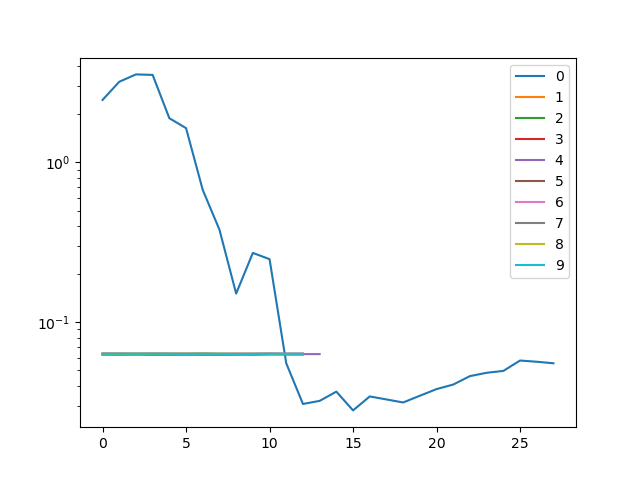

In [26]:
plt.figure()
for i in range(10):
    plt.plot([h["error"] for h in result["hist"][i]], label=f"{i}")

plt.legend()
plt.yscale("log")

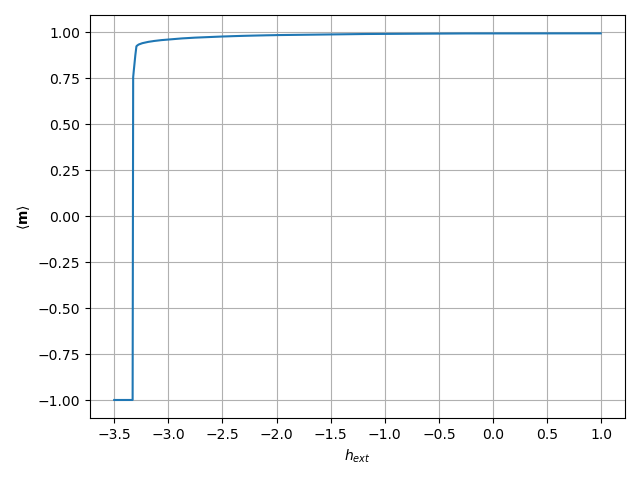

In [27]:
plt.figure()
plt.plot(hext, result["mean_mags"], "-")
#plt.xlim((-3.5, 1.))
#plt.ylim((-1.1, 1.1))
plt.grid()
plt.xlabel("$h_{ext}$")
plt.ylabel("$\\langle \\mathbf{m}\\rangle$")
plt.xticks(np.linspace(-3.5, 1, 10));
plt.tight_layout()


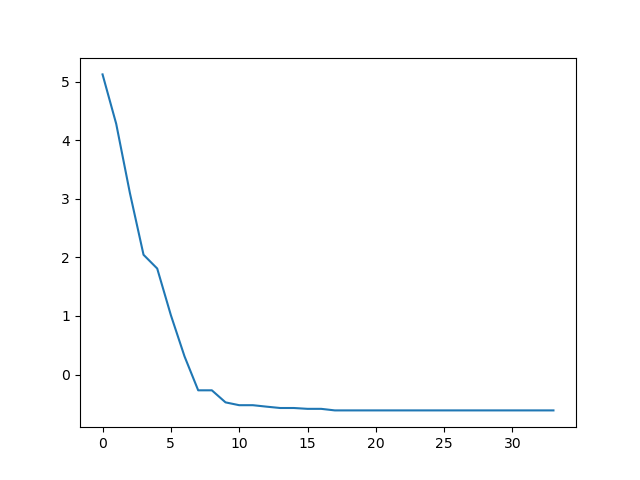

In [52]:
plt.figure()
plt.plot([h["loss"] for h in result["hist2"][0][0]])
#plt.plot(hext, mean_mags)

In [44]:

len(result["hist1"][0])

1

In [45]:
result["hist1"][0]

[[{'loss': array(5.123274, dtype=float32),
   'error': array(2.032486, dtype=float32),
   'aux': {'e_ani': array(1.2192476, dtype=float32),
    'e_ex': array(0.0088851, dtype=float32),
    'e_ext': array(0.1239554, dtype=float32),
    'e_mag': array(1.8855929, dtype=float32),
    'e_tot': array(3.2376812, dtype=float32)},
   'rho': array(0.81465465, dtype=float32),
   'tr_radius': array(0.2, dtype=float32),
   'steihaug_curvature': array(-1.439033, dtype=float32)},
  {'loss': array(4.279291, dtype=float32),
   'error': array(1.7142277, dtype=float32),
   'aux': {'e_ani': array(1.0696917, dtype=float32),
    'e_ex': array(0.01035407, dtype=float32),
    'e_ext': array(0.22465353, dtype=float32),
    'e_mag': array(1.4872961, dtype=float32),
    'e_tot': array(2.7919953, dtype=float32)},
   'rho': array(2.1033397, dtype=float32),
   'tr_radius': array(0.4, dtype=float32),
   'steihaug_curvature': array(1.0820748, dtype=float32)},
  {'loss': array(3.100504, dtype=float32),
   'error': arr

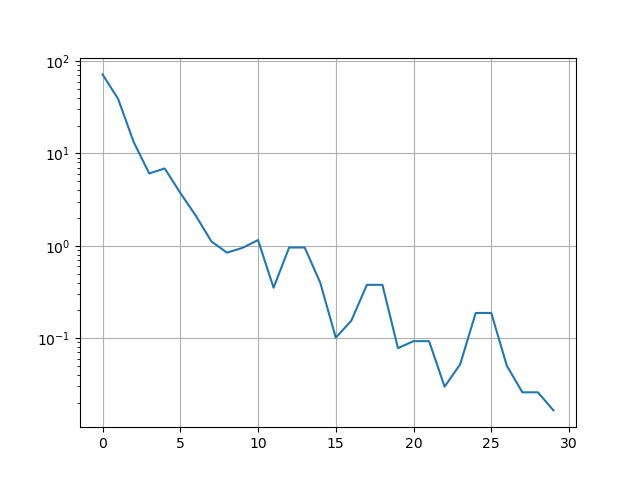

In [20]:
fig = plt.figure()
plt.plot([h["error"] for h in hist_loss2][:30])
plt.grid()
plt.yscale("log")


In [16]:
_weights = array(Halton(4, seed=132).random(2 ** 10))
#_weights = random.uniform(key, (700, 4))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
h_elm = lambda x: tanh(W_elm @ (domain.normalize(x)) + b_elm)
u_elm = lambda x: h_elm(x) * domain.adf(x)
Q = vmap(lambda x: laplace(u_elm)(x))(X)
U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
Pinv = VT.T * (1 / S) @ U.T
f = lambda x: -curl(m_vortex)(x)
b1 = vmap(f)(X)
params_A1 = Pinv @ b1
#A1 = lambda x: u_elm(x) @ params_A1
A1 = lambda x: h_elm(x) @ params_A1

In [18]:
mag_energy(domain, A1, m_vortex, (X_val, Z_val, grad_Z_val)) / 2

Array(0.02234562, dtype=float32)

In [7]:
#X_train = X[vmap(domain.adf)(X) < 30]
X_train = X

In [89]:
from magpi.opt import batches_without_replacement, batches_with_replacement

batch_size_dom = 200


def train(key, optimizer, params, mag, epochs, batch_size_dom):
    @jit
    def update(params, opt_state, data):
        (_loss, _aux), grads = value_and_grad(loss, has_aux=True)(params, data, mag)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (_loss, _aux)
    
    opt_state = optimizer.init(params)
    losses = []
    #energies = []
    for epoch in range(epochs):
        key, k1, k2 = random.split(key, 3)
        x = batches_without_replacement(k1, X_train, batch_size_dom)
        batches = x.shape[0]
        _losses = []
        #_energies = []
        
        for batch in range(batches):
            data = tree_map(lambda a: a[batch], x)
            params, opt_state, (_loss, _aux) = update(params, opt_state, data)
            _losses.append(_loss)
            #_energies.append(_aux)
            
        losses.append(mean(asarray(_losses)))
        #energies.append(tree_map(lambda *a: mean(asarray(a)), *_energies))
        
    losses = asarray(losses)
    #energies = (tree_map(lambda *a: stack(a), *energies))
    return params, losses  # (losses, energies)

In [149]:
key, _k = random.split(key)

epochs = 10000
_reductions = 2
_n_batches = X.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs / _reductions
schedule = optax.exponential_decay(1e-3, _transition_steps, 0.1)
# optimizer = optax.adamw(schedule)
optimizer = optax.adamw(1e-3)

opt_step, losses = train(_k, optimizer, vec_pot_params_init, m_flower, epochs, batch_size_dom)

In [139]:
X_train = X
from jaxopt import LBFGS, NonlinearCG
from magpi.opt import TR

optim = LBFGS(lambda p, x: loss(p, x, m_flower), has_aux=True, maxiter=20000, history_size=50, maxls=500, min_stepsize=1e-9, tol=1e-3)
#optim = NonlinearCG(lambda p, x: loss(p, x, m_flower), has_aux=True, maxiter=1000,)
#optim = TR(lambda p, x: loss(p, x, m_flower), has_aux=True, maxiter=10000, tol=1e-3)
state = optim.run(vec_pot_params_init, X_train)

In [150]:
#params = state.params
_A1 = lambda x: A1(x, opt_step)

In [141]:
state.state.error, state.state.value, state.state.iter_num

(Array(0.00093915, dtype=float32),
 Array(0.00092699, dtype=float32),
 Array(16884, dtype=int32, weak_type=True))

In [27]:
_weights = array(Halton(4, seed=1362).random(2 ** 9))
#_weights = random.uniform(key, (700, 4))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
h_elm = lambda x: tanh(W_elm @ (domain.normalize(x)) + b_elm)
u_elm = lambda x: h_elm(x) * domain.adf(x)
Q = vmap(lambda x: laplace(u_elm)(x))(X_train)
U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
Pinv = VT.T * (1 / S) @ U.T
f = lambda x: -curl(m_flower)(x)
b1 = vmap(f)(X_train)
params_A1 = Pinv @ b1
#A1 = lambda x: u_elm(x) @ params_A1
_A1 = lambda x: h_elm(x) @ params_A1

(100, 100, 3)

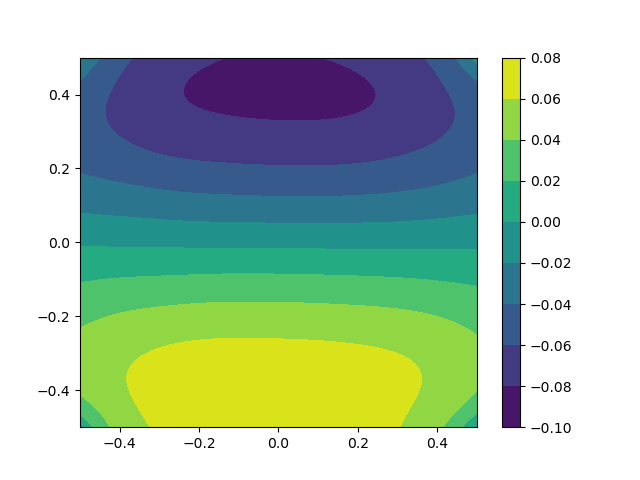

In [151]:
import matplotlib.pyplot as plt

fig = plt.figure()
W = jnp.stack(meshgrid(
    linspace(-0.5, 0.5, 100),
    linspace(-0.5, 0.5, 100),
    array([-0.]),
    indexing="xy"
), axis=-1)[:, :, 0]

a = jnp.apply_along_axis(_A1, -1, W)
plt.contourf(W[..., 0], W[..., 1], a[..., 0])
plt.colorbar()
W.shape


In [152]:
state.state.error, state.state.value

(Array(0.00093915, dtype=float32), Array(0.00092699, dtype=float32))

In [153]:

mag_energy(_A1, m_flower, X_val, Z_val, grad_Z_val) / 2

Array(0.15309131, dtype=float32)

In [154]:
lA1 = lambda x: domain.adf(x) * _A1(x)

bs = lambda x, dt: (curl(lA1)(x) + curl_A2(domain, _A1, m_flower, dt))

def mag_energy2(bs, m, x, xt):
    def e_mag(x, xt):
        e = lambda x: 1 - dot(m(x), bs(x, xt))
        return e(x)

    return mean(vmap(e_mag)(x, xt))

mag_energy2(bs, m_flower, X_val, grad_Z_val) / 2

Array(0.1540015, dtype=float32)

In [155]:
@partial(jit, static_argnames="mag")
def _strong_loss(data, mag):
    X = data
    lA1 = lambda x: domain.adf(x) * _A1(x)
    def _loss_strong(x):
        return norm(laplace(lA1)(x) + curl(mag)(x)) ** 2
    
    l = mean(vmap(_loss_strong)(X))
    return l, l

_strong_loss(X_val, m_flower)

(Array(0.01103982, dtype=float32), Array(0.01103982, dtype=float32))

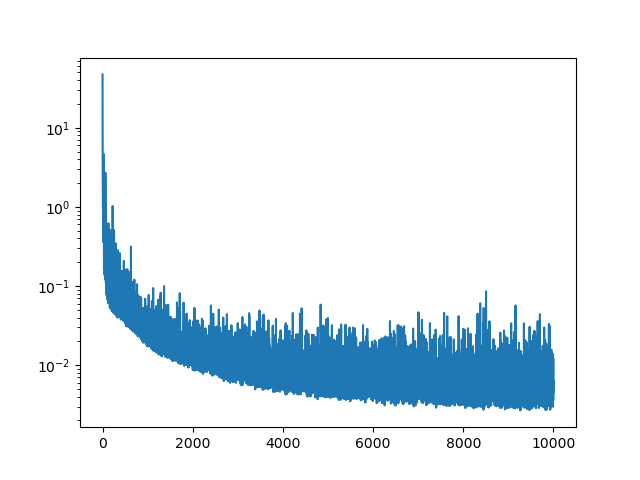

In [156]:
fig = plt.figure()

plt.plot(losses)
plt.yscale('log')

In [12]:
_weights = array(Halton(4, seed=1362).random(2 ** 9))
#_weights = random.uniform(key, (700, 4))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
h_elm = lambda x: tanh(W_elm @ (domain.normalize(x)) + b_elm)
u_elm = lambda x: h_elm(x) * domain.adf(x)
Q = vmap(lambda x: laplace(u_elm)(x))(X_train)
U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
Pinv = VT.T * (1 / S) @ U.T
f = lambda x: -curl(m_flower)(x)
b1 = vmap(f)(X_train)
params_A1 = Pinv @ b1
#A1 = lambda x: u_elm(x) @ params_A1
_A1 = lambda x: h_elm(x) @ params_A1

In [36]:
def solve_A1(m):
    h_elm = lambda x: tanh(W_elm @ (domain.normalize(x)) + b_elm)
    u_elm = lambda x: h_elm(x) * domain.adf(x)
    Q = vmap(lambda x: laplace(u_elm)(x))(X_train)
    U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
    Pinv = VT.T * (1 / S) @ U.T
    f = lambda x: -curl(m)(x)
    b1 = vmap(f)(X_train)
    params_A1 = Pinv @ b1
    lA1 = lambda x: u_elm(x) @ params_A1
    A1 = lambda x: h_elm(x) @ params_A1
    return A1, lA1


def m(x, p):
    # mx = x[..., 0] * x[..., 2]
    # my = p * x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    # mz = ones_like(my)
    # mag = stack([mx, my, mz], axis=-1)
    # return unit_vec(mag)
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = p#0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)



def loss1(x, z, grad_z, p):
    _m = lambda x: m(x, p)
    __m = lambda x: m(x, lax.stop_gradient(p))
    A1, lA1 = solve_A1(__m)
    JA1 = JA1 = jacfwd(lA1)(x)
    _A2 = A2(domain, A1, _m, z)
    _curl_A2 = curl_A2(domain, A1, _m, grad_z)
    _grad_A2 = grad_A2(domain, A1, _m, grad_z)
    return (- curl(m)(x, p) @ _A2
            + m(x, p) @ _curl_A2
            - laplace(lA1)(x) @ _A2
            - jnp.sum(JA1 * _grad_A2))
    
    
def loss2(x, z, grad_z, p):
    _m = lambda x: m(x, p)
    __m = lambda x: m(x, lax.stop_gradient(p))
    A1, lA1 = solve_A1(__m)
    JA1 = JA1 = jacfwd(lA1)(x)
    _A2 = A2(domain, A1, _m, z)
    _curl_A2 = curl_A2(domain, A1, _m, grad_z)
    _grad_A2 = grad_A2(domain, A1, _m, grad_z)
    return 2 * (-curl(_m)(x) @ lax.stop_gradient(_A2)
            + m(x, p) @ lax.stop_gradient(_curl_A2))
            #- laplace(lA1)(x) @ lax.stop_gradient(_A2)
            #- jnp.sum(JA1 * lax.stop_gradient(_grad_A2)))
    


In [37]:
f = lambda p: mean(vmap(lambda x, z, grad_z: loss1(x, z, grad_z, p))(X, Z, grad_Z))
grad(f)(0.14)

Array(-0.02847774, dtype=float32, weak_type=True)

In [38]:
f = lambda p: mean(vmap(lambda x, z, grad_z: loss2(x, z, grad_z, p))(X, Z, grad_Z))
grad(f)(0.14)

Array(-0.02941235, dtype=float32, weak_type=True)

In [99]:
f = lambda p: mean(vmap(lambda x, dz: m_dot_h(x, dz, p))(X_val, grad_Z_val))
grad(f)(1.0)

Array(-0.01260286, dtype=float32, weak_type=True)

In [ ]:
dm1 = lax.map(lambda x: grad(m_dot_h, 1)(x, 1.0), X)

In [ ]:
dm2 = vmap(lambda x, dz: grad(m_dot_h, 2)(x, dz, 1.0))(X, grad_Z)

In [35]:
def m(x, p):
    mx = x[..., 0] * x[..., 2]
    my = p * x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

# x = X[0]
# z = tree_map(lambda t: t[0], Z)
# z = tree_map(lambda t: t[0], grad_Z)
lA1 = lambda x: domain.adf(x) * _A1(x)

def m_dot_curl_A(x, grad_z, p):
    _curl_A1 = curl(lA1)(x)
    _curl_A2 = curl_A2(domain, _A1, lambda x: m(x, p), grad_z)
    return - dot(m(x, p), (_curl_A1 + _curl_A2))# + norm(m(x, p)) ** 2

def m_dot_curl_A_2(x, p):
    curl_A1 = curl(lA1)(x)
    def g(y):
        _m = m(y, p)
        n = domain.normal_vec(y)
        return jnp.cross(_m, n) + _A1(y)
    A2 = single_layer_potential(domain, g, subintervals=5, method=gauss(5))
    curl_A2 = curl(A2)(x)
    return - dot(m(x,p), curl_A1 + curl_A2)# + norm(m(x, p)) ** 2


# _curl_A1 = curl(lA1)(x)
# _A2 = A2(domain, _A1, m, z)
# _curl_A2 = curl_A2(domain, _A1, m, grad_z)
# _grad_A2 = grad_A2(domain, _A1, m, grad_z)
#bs = curl(lA1)(x) + curl_A2(domain, A1, m, xt)

#@jax.custom_vjp
# def m_dot_curl_A(x, grad_z, p):
#     _curl_A1 = curl(lA1)(x)
#     _curl_A2 = curl_A2(domain, _A1, m, grad_z)
#     return - dot(m(x, p), _curl_A1 + _curl_A2)

# def m_dot_curl_A_fwd(x, grad_z, ):
#     _curl_A1 = curl(lA1)(x)
#     _curl_A2 = curl_A2(domain, _A1, m, grad_z)
#     _m = m(x)
#     primals_out = - dot(_m, _curl_A1 + _curl_A2)
#     return primals_out, (_m, grad_z, _curl_A1, _curl_A2, x)

# def m_dot_curl_A_bwd(res, g):
#     _m, grad_z, _curl_A1, _curl_A2, x = res
# #    print(g)
#     p = - 2 * dot(jacrev(m)(x), _curl_A1 + _curl_A2)  #- 2 * dot(g)
# #    print(p.shape)
#     return (p, tree_map(zeros_like, grad_z))

#m_dot_curl_A.defvjp(m_dot_curl_A_fwd, m_dot_curl_A_bwd)

# mean(vmap(grad(m_dot_curl_A))(X[:50]), axis=0)

In [23]:
dm1 = lax.map(lambda x: grad(m_dot_curl_A_2, 1)(x, 1.0), X)

In [36]:
dm2 = vmap(lambda x, dz: grad(m_dot_curl_A, 2)(x, dz, 1.0))(X, grad_Z)

In [37]:
mean(dm1), mean(dm2)

(Array(0.0148807, dtype=float32), Array(0.01504805, dtype=float32))

In [25]:

# def _m_dot_curl_A(x):
#     curl_A1 = curl(lA1)(x)
#     def g(y):
#         _m = m(y)
#         n = domain.normal_vec(y)
#         return jnp.cross(_m, n) + _A1(y)
#     A2 = single_layer_potential(domain, g, subintervals=5, method=gauss(5))
#     curl_A2 = curl(A2)(x)
#     assert(curl_A2.shape == (3,))
#     return - dot(m(x), curl_A1 + curl_A2)

def _m_dot_curl_A(p, x):
    def g(y):
        _m = m(y, p)
        #n = -jacfwd(domain.adf)(y)
        n = domain.normal_vec(y)
        return jnp.cross(_m, n) + _A1(y)
    A2 = single_layer_potential(domain, g, subintervals=5, method=gauss(9))
    curl_A2 = (A2)(x)
    assert(curl_A2.shape == (3,))
    n = domain.normal_vec(x)
    #n = -jacfwd(domain.adf)(x)
    dA = jacfwd(lA1)(x) @ n
    return - dot(cross(m(x, p), n) - dA, curl_A2)

#mean(vmap(jacfwd(_m_dot_curl_A))(X[:50]), axis=0)#, grad(_m_dot_curl_A)(x)

In [29]:
x = array([-0.5, 0.1, 0.1])
jacfwd(_m_dot_curl_A)(1.0, x)

Array(0.00052695, dtype=float32)

In [33]:


def m_dot_curl_A(p, x):
    z = surface_tensors(x, domain, 5, gauss(9))
    _curl_A2 = A2(domain, _A1, lambda x: m(x, p), z)
    n = domain.normal_vec(x)
    dA = jacfwd(lA1)(x) @ n
    return - 2 * dot(cross(jacfwd(m, 1)(x, p), n), lax.stop_gradient(_curl_A2))

m_dot_curl_A(1.0, x)

Array(2.4408546e-05, dtype=float32)

In [28]:
jacfwd(lambda p: m(x, p))(1.0)

Array([0., 0., 0.], dtype=float32)

In [287]:
_m_dot_curl_A(x), m_dot_curl_A(x, surface_tensors(x, domain, 5, gauss(9))) / 2

(3,) (3,)


(Array(0.01366102, dtype=float32), Array(0.01366102, dtype=float32))

In [35]:
# def double_integrate(
#     f,
#     domain1: list[Array],
#     domain2: list[Array],
#     *args,
#     method1: QuadRule = gauss(4),
#     method2: QuadRule = gauss(3),
#     **kwargs
# ) -> Array:

#     W1, X1 = zip(*(method1(d) for d in domain1))
#     W1 = stack(jnp.meshgrid(*W1), axis=-1)
#     X1 = stack(jnp.meshgrid(*X1), axis=-1)
#     W1 = jnp.prod(W1, axis=-1)

#     def integrand(y):
#         def g(x):
#             return f(x, y, *args, **kwargs)

#         F = jnp.apply_along_axis(g, -1, X1)
#         if W1.shape == F.shape:
#             return jnp.sum(W1 * F, axis=list(range(len(domain1))))
#         else:
#             return jnp.sum(W1[..., None] * F, axis=list(range(len(domain1))))
        
#     W2, X2 = zip(*(method2(d) for d in domain2))
#     W2 = stack(jnp.meshgrid(*W2), axis=-1)
#     X2 = stack(jnp.meshgrid(*X2), axis=-1)
#     W2 = jnp.prod(W2, axis=-1)
#     F2 = jnp.apply_along_axis(integrand, -1, X2)
    
#     if W2.shape == F2.shape:
#         return jnp.sum(W2 * F2, axis=list(range(len(domain2))))
#     else:
#         return jnp.sum(W2[..., None] * F2, axis=list(range(len(domain2))))
#     #return jnp.tensordot(W, F, len(domain))


# @partial(jit, static_argnames=("f", "domain", "method1", "method2"))
# def double_surface_integral(f, domain, method1, method2, *args, **kwargs):
#     def _int(face1, face2):
#         dom1_face1 = face1.axis1_vals
#         dom2_face1 = face1.axis2_vals
#         dom1_face2 = face2.axis1_vals
#         dom2_face2 = face2.axis2_vals

#         def integrand(x, y):
#             (x0, x1), (y0, y1) = x, y
#             x = zeros((3,))
#             y = zeros((3,))
#             x = x.at[face1.axis1].set(x0)
#             x = x.at[face1.axis2].set(x1)
#             x = x.at[face1.const_axis].set(face1.const_val)
#             y = y.at[face2.axis1].set(y0)
#             y = y.at[face2.axis2].set(y1)
#             y = y.at[face2.const_axis].set(face2.const_val)
#             return f(x, y, *args, **kwargs)
            
#         return double_integrate(integrand, [dom1_face1, dom2_face1], [dom1_face2, dom2_face2], method1=method1, method2=method2)

#     def body1(face1):
#         def body2(face2):
#             face_contribution = _int(face1, face2)
#             return face_contribution
#         return tree_map(body2, domain.faces)
    
#     result = asarray(tree_map(body1, domain.faces))
#     return jnp.sum(result)
#     # result = zeros(())
#     # def body1(i, result):
#     #     def body2(j, result):
#     #         print("bar")
#     #         face_contribution = _int(domain.faces[i], domain.faces[j])
#     #         print("fooo")
#     #         return result + face_contribution
#     #     return lax.fori_loop(0, 6, body2, result, unroll=False)
#     # result = lax.fori_loop(0, 6, body1, result, unroll=False)
#     # return result
 
#     # def body1(face1):
#     #     def body2(face2):
#     #         print("bar")
#     #         face_contribution = _int(face1, face2)
#     #         print("fooo")
#     #         return face_contribution
#     #     return lax.map(body2, domain.faces)
#     # result = lax.map(body1, domain.faces)
#     # return jnp.sum(result)
 
 
#     # for face1 in domain.faces:
#     #     for face2 in domain.faces:
#     #         face_contribution = _int(face1, face2)
#     #         result = result + face_contribution
#     # return result
    
    
# # class VecPotential(nn.Module):
# #     @nn.compact
# #     def __call__(self, x):
# #         nodes = 20
# #         activation = nn.gelu
# #         #y = concatenate([x, lam.ravel()])
# #         y = activation(nn.Dense(nodes, name="dense1")(x))
# #         y = activation(nn.Dense(nodes, name="dense2")(y))
# #         y = activation(nn.Dense(nodes, name="dense3")(y))
# #         y = activation(nn.Dense(nodes, name="dense4")(y))
# #         y = activation(nn.Dense(nodes, name="dense5")(y))
# #         y = activation(nn.Dense(nodes, name="dense6")(y))
# #         y = nn.Dense(3, name="dense7")(y)
# #         return y

# # key, _k = random.split(key)
# # A1_model = VecPotential()
# # vec_pot_params_init = A1_model.init(_k, zeros((3,)))

# # def A1(x):
# #     return A1_model.apply(vec_pot_params_init, x)

# # f = lambda x, y: (A1(x) @ A1(y)) / (norm(x - y))

# # double_surface_integral(f, domain, gauss(9), gauss(10))
    


In [36]:

# def A2(domain, A1, m, x_tensor):
#     def g(y):
#         _m = m(y)
#         n = domain.normal_vec(y)
#         return jnp.cross(_m, n) + A1(y)

#     c = charges(domain, g)
#     _A2 = lambda dt: 1 / (4 * pi) * _solve_sufrace_integral(c, dt)
#     return _A2(x_tensor)    

# def _solve_sufrace_integral(charges, target) -> Array:
#     def _dot_sum(a, b):
#         return jnp.sum(a * b[..., None], axis=(0,1,2))

#     face_contributions = tree_map(lambda c, t: _dot_sum(c, t), charges, target)
#     A2 = jnp.sum(array(face_contributions), axis=0)
#     return A2

def curl_A2(domain, A1, m, x_tensor_grad):
    def g(y):
        _m = m(y)
        n = domain.normal_vec(y)
        return jnp.cross(_m, n) + A1(y)

    c = charges(domain, g)
    curl_A2 = lambda dt: 1 / (4 * pi) * _solve_curl_sufrace_integral(c, dt)
    return curl_A2(x_tensor_grad)    

def _solve_curl_sufrace_integral(charges, target) -> Array:
    def _dot_sum(a, b):
        return jnp.sum(-jnp.cross(a, b), axis=(0,1,2))

    face_contributions = tree_map(lambda c, t: _dot_sum(c, t), charges, target)
    curl_A2 = jnp.sum(array(face_contributions), axis=0)
    return curl_A2


In [44]:
class VecPotential(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 20
        activation = nn.gelu
        #y = concatenate([x, lam.ravel()])
        y = activation(nn.Dense(nodes, name="dense1")(x))
        y = activation(nn.Dense(nodes, name="dense2")(y))
        y = activation(nn.Dense(nodes, name="dense3")(y))
        y = activation(nn.Dense(nodes, name="dense4")(y))
        y = activation(nn.Dense(nodes, name="dense5")(y))
        y = activation(nn.Dense(nodes, name="dense6")(y))
        y = nn.Dense(3, name="dense7")(y)
        return y

key, _k = random.split(key)
A1_model = VecPotential()
vec_pot_params_init = A1_model.init(_k, zeros((3,)))

def A1(x, params):
    return A1_model.apply(params, x)


def mag_energy(A1, m, x, xt):
    lA1 = lambda x: domain.adf(x) * A1(x)
    def e_dom(x, xt):
        JA1 = jacfwd(lA1)(x)
        bs = curl(lA1)(x) + curl_A2(domain, A1, m, xt)
        e = lambda x: (
            1  #norm(m(x)) ** 2
            + jnp.sum(JA1 * JA1)
            - 2 * dot(m(x), bs)
        )
        return e(x)

    def e_bnd():
        def _f(x, y):
            nx = domain.normal_vec(x)
            ny = domain.normal_vec(y)
            charge = (cross(m(x), nx) + A1(x)) @ (cross(m(y), ny) + A1(y))
            return charge / (norm(x - y))
        
        return 1 / (4 * pi) * double_surface_integral(_f, domain, gauss(8), gauss(10))
    
    return mean(vmap(e_dom)(x, xt)) + e_bnd()

@partial(jit, static_argnames="mag")
def loss(params, data, mag):
    x, xt = data
    _A1 = lambda x: A1(x, params)
    es = mag_energy(_A1, mag, x, xt)
    return es, es

In [45]:
from magpi.opt import batches_without_replacement, batches_with_replacement

batch_size_dom = 500


def train(key, optimizer, params, mag, epochs, batch_size_dom):
    @jit
    def update(params, opt_state, data):
        (_loss, _aux), grads = value_and_grad(loss, has_aux=True)(params, data, mag)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (_loss, _aux)
    
    opt_state = optimizer.init(params)
    losses = []
    #energies = []
    for epoch in range(epochs):
        key, k1, k2 = random.split(key, 3)
        x, xt = batches_without_replacement(k1, (X, Z), batch_size_dom)
        batches = x.shape[0]
        _losses = []
        #_energies = []
        
        for batch in range(batches):
            data = tree_map(lambda a: a[batch], (x, xt))
            params, opt_state, (_loss, _aux) = update(params, opt_state, data)
            _losses.append(_loss)
            #_energies.append(_aux)
            
        losses.append(mean(asarray(_losses)))
        #energies.append(tree_map(lambda *a: mean(asarray(a)), *_energies))
        
    losses = asarray(losses)
    #energies = (tree_map(lambda *a: stack(a), *energies))
    return params, losses  # (losses, energies)

In [ ]:
X_train = array(Halton(3, seed=41).random(2**15))
X_train = domain.transform(X_train)

In [46]:
key, _k = random.split(key)

epochs = 150
_reductions = 2
_n_batches = X.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

opt_step, losses = train(_k, optimizer, vec_pot_params_init, m_flower, epochs, batch_size_dom)

In [50]:
_A1 = lambda x: A1(x, opt_step)

def _map(f):
    def _inner(*args):
        _f = lambda args: f(*args)
        return lax.map(_f, args)
    return _inner

@partial(jit, static_argnames=("A1", "m"))
def _mag_energy(A1, m, x, xt):
    lA1 = lambda x: domain.adf(x) * A1(x)
    def e_dom(x, xt):
        JA1 = jacfwd(lA1)(x)
        bs = curl(lA1)(x) + curl_A2(domain, A1, m, xt)
        e = lambda x: (
            norm(m(x)) ** 2
            + jnp.sum(JA1 * JA1)
            - 2 * dot(m(x), bs)
        )
        return e(x)

    def e_bnd():
        def _f(x, y):
            nx = domain.normal_vec(x)
            ny = domain.normal_vec(y)
            charge = (cross(m(x), nx) + A1(x)) @ (cross(m(y), ny) + A1(y))
            return charge / (norm(x - y))
        
        return 1 / (4 * pi) * double_surface_integral(_f, domain, gauss(8), gauss(10))
    
    return mean(_map(e_dom)(x, xt)) + e_bnd()

In [51]:
_mag_energy(_A1, m_flower, X, Z) / 2

Array(0.15295121, dtype=float32)

In [13]:
0.1528

0.1528

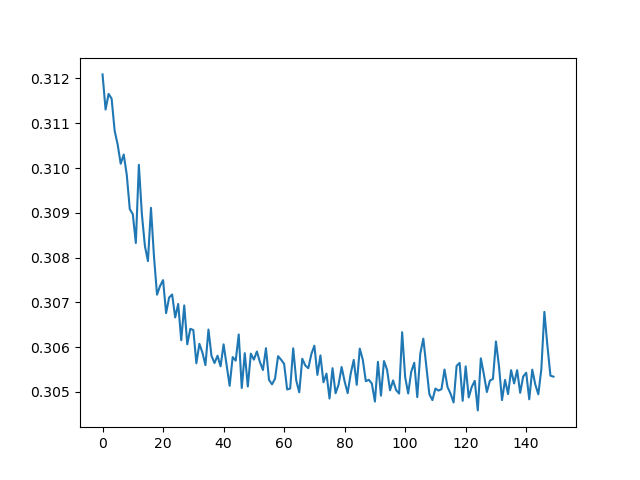

In [52]:
fig = plt.figure()
plt.plot(losses)

In [13]:
0.306 /2

0.153

In [ ]:
# _x_tensor = tree_map(lambda t: t[0], x_tensor_bnd)
# _surface_integral(domain, A1, m_flower, _x_tensor, asarray(8.0), vec_pot_params_init)
# _x_tensor = tree_map(lambda t: t[0], x_tensor_dom)
# _curl_surface_integral(domain, A1, m_flower, _x_tensor, asarray(8.0), vec_pot_params_init)

In [ ]:


class PINN(nn.Module):
    @nn.compact
    def __call__(self, x, lam):
        nodes = 50
        activation = nn.gelu
        y = concatenate([x, lam.ravel()])
        y = activation(nn.Dense(nodes, name="dense1")(y))
        y = activation(nn.Dense(nodes, name="dense2")(y))
        y = activation(nn.Dense(nodes, name="dense3")(y))
        y = activation(nn.Dense(nodes, name="dense4")(y))
        y = activation(nn.Dense(nodes, name="dense5")(y))
        y = activation(nn.Dense(nodes, name="dense6")(y))
        y = nn.Dense(3, name="dense7")(y)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)), zeros(()))

class VecPotential(nn.Module):
    @nn.compact
    def __call__(self, x, lam):
        nodes = 50
        activation = nn.gelu
        y = concatenate([x, lam.ravel()])
        y = activation(nn.Dense(nodes, name="dense1")(y))
        y = activation(nn.Dense(nodes, name="dense2")(y))
        y = activation(nn.Dense(nodes, name="dense3")(y))
        y = activation(nn.Dense(nodes, name="dense4")(y))
        y = activation(nn.Dense(nodes, name="dense5")(y))
        y = activation(nn.Dense(nodes, name="dense6")(y))
        y = nn.Dense(3, name="dense7")(y)
        return y

key, _k = random.split(key)
A1_model = VecPotential()
vec_pot_params_init = A1_model.init(_k, zeros((3,)), zeros(()))

def A1(x, lam, params):
    return A1_model.apply(params, x, lam)


def mag(mag0, x, lam, params):
    x = domain.normalize(x)
    p = mag_pinn_model.apply(params, x, lam)
    m = mag0(x)
    return cayley_rotation(p, m)

def exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2

    return 0.1 * mean(vmap(e_ani)(x))

def mag_energy(A1, m, x, xt, x_bnd, xt_bnd):
    lA1 = lambda x: domain.adf(x) * A1(x)
    def e_dom(x, xt):
        JA1 = jacfwd(lA1)(x)
        bs = curl(lA1)(x) + curl_A2(domain, A1, m, xt)
        e = lambda x: (
            norm(m(x)) ** 2
            + jnp.sum(JA1 * JA1)
            - 2 * dot(m(x), bs)
        )
        return e(x)

    def e_bnd(x, xt):
        n = -jacfwd(domain.adf)(x)
        return (m(x) @ n + A1(x)) @ A2(domain, A1, m, xt)
    
    return mean(vmap(e_dom)(x, xt)) + mean(vmap(e_bnd)(x_bnd, xt_bnd))

# def mag_energy(bs, m, x, xt):
#     def e_mag(x, xt):
#         e = lambda x: - dot(m(x), bs(x, xt))
#         return e(x)

#     return mean(vmap(e_mag)(x, xt))

# def norm_m(m, x):
#     norm_m = lambda x: norm(m(x)) ** 2
#     return mean(vmap(norm_m)(x))

@partial(jit, static_argnames="mag0")
def loss(params, data, mag0):
    x, xt, x_bnd, xt_bnd, lam = data
    lam = array(lam)
    def _loss(lam):
        _mag = lambda x: mag(mag0, x, lam, params["mag"])
        _A1 = lambda x: A1(x, lam, params["A1"])
        e_ex = exchange_energy(_mag, x, lam)
        e_ani = ani_energy(_mag, x)
        e_mag = mag_energy(_A1, _mag, x, xt, x_bnd, xt_bnd)

        l = e_ex + e_ani + e_mag
        return l, {
            'e_tot': e_ex + e_ani + e_mag,
            'e_mag': e_mag,
            'e_ex': e_ex,
            'e_ani': e_ani,
        }
    return tree_map(mean, vmap(_loss)(lam))
    

In [ ]:
from magpi.opt import batches_without_replacement

batch_size_dom = 500
batch_size_lam = 5



def train(key, optimizer, params, mag0, epochs, batch_size_dom, batch_size_lam):
    @jit
    def update(params, opt_state, data):
        (_loss, _aux), grads = value_and_grad(loss, has_aux=True)(params, data, mag0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (_loss, _aux)
    
    opt_state = optimizer.init(params)
    losses = []
    energies = []
    for epoch in range(epochs):
        key, k1, k2 = random.split(key, 3)
        x, xt = batches_without_replacement(k1, (X, Z), batch_size_dom)
        batches = x.shape[0]
        lam = random.uniform(k2, (batches, batch_size_lam), minval=8, maxval=9)
        _losses = []
        _energies = []
        
        for batch in range(batches):
            data = tree_map(lambda a: a[batch], (x, xt, lam))
            params, opt_state, (_loss, _aux) = update(params, opt_state, data)
            _losses.append(_loss)
            _energies.append(_aux)
            
        losses.append(mean(asarray(_losses)))
        energies.append(tree_map(lambda *a: mean(asarray(a)), *_energies))
        
    losses = asarray(losses)
    energies = (tree_map(lambda *a: stack(a), *energies))
    return params, (losses, energies)

In [ ]:
epochs_flower = 7000
_reductions = 3
_n_batches = X.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_flower / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_flower, (losses_flower, energies_flower) = train(
    train_key, optimizer, pinn_params_init, m_flower, epochs_flower, batch_size_dom, batch_size_lam
)

In [ ]:

epochs_vortex = 7000
_reductions = 3
_n_batches = X.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_vortex / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_vortex, (losses_vortex, energies_vortex) = train(
    train_key, optimizer, pinn_params_init, m_vortex, epochs_vortex, batch_size_dom, batch_size_lam)

In [ ]:
from flax import serialization

with open("state_flower", "wb") as face:
    data = dict(params=params_flower, losses=losses_flower, energies=energies_flower)
    face.write(serialization.to_bytes(data))

with open("state_vortex", "wb") as face:
    data = dict(params=params_vortex, losses=losses_vortex, energies=energies_vortex)
    face.write(serialization.to_bytes(data))

In [ ]:
from flax import serialization
template = dict(params=pinn_params_init, losses=array([]), energies={
            'e_tot': array([]),
            'e_mag': array([]),
            'e_ex': array([]),
            'e_ani': array([]),
        })

with open("state_flower", "rb") as face:
    state_flower = serialization.from_bytes(template, face.read())
    params_flower = state_flower["params"]
    losses_flower = state_flower["losses"]
    energies_flower = state_flower["energies"]

with open("state_vortex", "rb") as face:
    state_vortex = serialization.from_bytes(template, face.read())
    params_vortex = state_vortex["params"]
    losses_vortex = state_vortex["losses"]
    energies_vortex = state_vortex["energies"]

In [ ]:
import dataclasses
@dataclasses.dataclass(frozen=True,eq=False)
class Plot:
    name: str
    label: str
    data: Array

In [ ]:

plt.rcParams.update({'font.size': 12})

def plot_hist(data):
    fig = plt.figure(figsize=(7, 5.5))
    axes = fig.subplots(4, 1)
    for i, p in enumerate(data):
        axes[i].plot(p.data[2:])
        axes[i].set_xscale("log")
        axes[i].set_ylabel(p.label)
        axes[i].grid(which='both')
        if i != 3:
            axes[i].set_xticklabels([])
        start, end = axes[i].get_ylim()
        axes[i].yaxis.set_ticks(np.linspace(start, end, 5))
        axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[-1].set_xlabel('epochs')
    fig.tight_layout()
    return fig

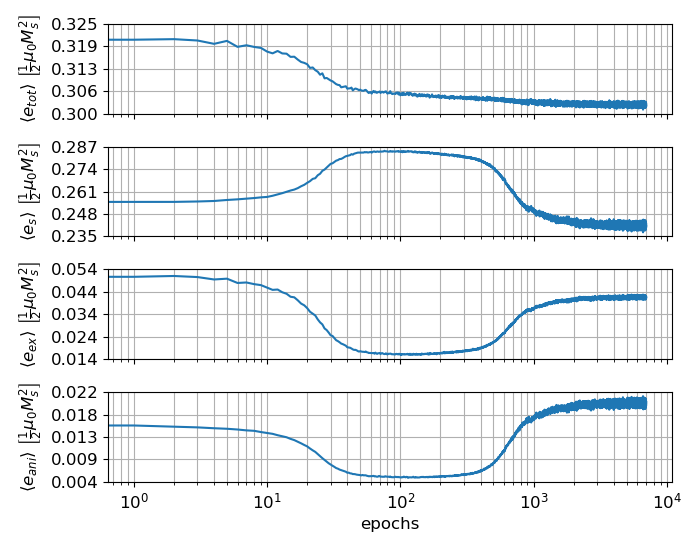

In [ ]:
plots_flower = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ani']),
]

fig_flower = plot_hist(plots_flower)

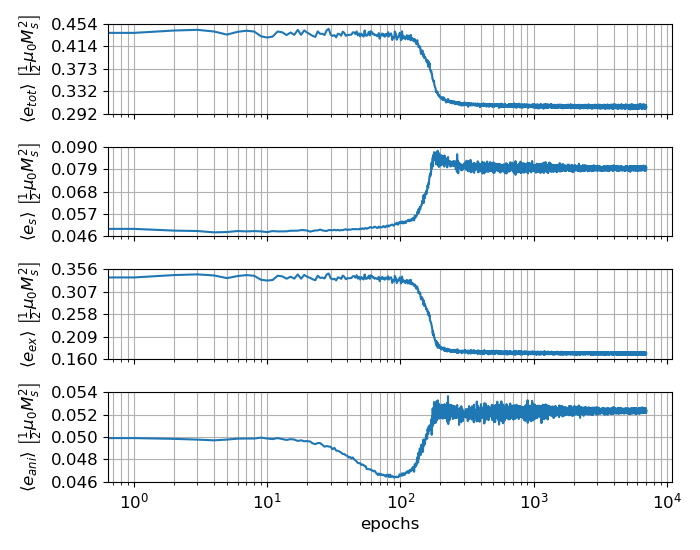

In [ ]:
plots_vortex = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ani']),
]

fig_vortex = plot_hist(plots_vortex)

In [ ]:
_x_dom = array(Halton(3, seed=121).random(2**13))
_x_dom = domain.transform(_x_dom)
_x_tensor_dom = lax.map(lambda x: surface_tensors_grad(x, domain, 15, gauss5), _x_dom)

def _map(f):
    def _inner(*args):
        _f = lambda args: f(*args)
        return lax.map(_f, args)
    return _inner

def _exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def _ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2

    return 0.1 * mean(vmap(e_ani)(x))

def _mag_energy(bs, m, x, xt):
    def e_mag(x, xt):
        e = lambda x: - dot(m(x), bs(x, xt))
        return e(x)

    return mean(vmap(e_mag)(x, xt))

@jit
def total_energy_flower(lam):
    lam = asarray(lam)
    m = lambda x: mag(m_flower, x, lam, params_flower)
    bs = stray_field_solver(m)
    e_ex = _exchange_energy(m, _x_dom, lam)
    e_ani = _ani_energy(m, _x_dom)
    e_mag = mag_energy(bs, m, _x_dom, _x_tensor_dom)
    # e_mag = (norm_m(m, _x_dom) + e_mag)
    e_mag = (1 + e_mag)
    e_tot = e_ex + e_ani + e_mag
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }

@jit
def total_energy_vortex(lam):
    lam = asarray(lam)
    m = lambda x: mag(m_vortex, x, lam, params_vortex)
    bs = stray_field_solver(m)
    e_ex = _exchange_energy(m, _x_dom, lam)
    e_ani = _ani_energy(m, _x_dom)
    e_mag = _mag_energy(bs, m, _x_dom, _x_tensor_dom)
    #e_mag = (norm_m(m, _x_dom) + e_mag)
    e_mag = (1 + e_mag)
    e_tot = e_ex + e_ani + e_mag
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }

# # @partial(jit, static_argnames=('mag0',))
# def total_energy(mag0, params, lam):
#     lam = asarray(lam)
#     m = lambda x: mag(mag0, x, lam, params)
#     bs = stray_field_solver(m)
#     e_ex = _exchange_energy(m, _x_dom, lam)
#     e_ani = _ani_energy(m, _x_dom)
#     e_mag = _mag_energy(bs, m, _x_dom, _x_tensor_dom)
#     # e_mag = (norm_m(m, _x_dom) + e_mag)
#     e_mag = (1 + e_mag)
#     e_tot = e_ex + e_ani + e_mag
#     return {
#         'e_tot': e_tot,
#         'e_mag': e_mag,
#         'e_ex': e_ex,
#         'e_ani': e_ani,
#     }
    
# def e(mag0, params, lam):
#     return total_energy(mag0, params, lam)['e_tot']

lam = jnp.arange(8, 9.01, 0.1)

In [ ]:
_energies_flower = lax.map(total_energy_flower, lam)
_energies_vortex = lax.map(total_energy_vortex, lam)

2024-03-07 16:28:56.031221: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.314 = f32[8192,8,8,6,1]{4,3,2,1,0} slice(f32[8192,8,8,6,3]{4,3,2,1,0} %constant.565), slice={[0:8192], [0:8], [0:8], [0:6], [2:3]}, metadata={op_name="jit(scan)/jit(main)/while/body/jit(total_energy_flower)/vmap(jit(cross))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1, 2, 3), collapsed_slice_dims=(4,), start_index_map=(4,)) slice_sizes=(8192, 8, 8, 6, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/tmp/ipykernel_12459/4010465120.py" source_line=35}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like 

In [ ]:
import numpy as np
from scipy.optimize import bisect




def _e_flower(lam):
    return np.array(total_energy_flower(lam)["e_tot"])

def _e_vortex(lam):
    return np.array(total_energy_vortex(lam)["e_tot"])

def energy_difference(lam):
    vortex = _e_vortex(array(lam))
    flower = _e_flower(array(lam))
    return vortex - flower

cross_section = array(bisect(energy_difference, 8., 9.))
cross_section_energy = total_energy_flower(cross_section)["e_tot"]
cross_section

Array(8.561311, dtype=float32, weak_type=True)

In [ ]:
def format_arr(a):
    a = np.array(a)
    a = np.round(a, 4)
    if len(a.shape) == 0:
        return f"{a:.4f}"
    return np.array_str(a, precision=4, suppress_small=True)

print(tree_map(format_arr, total_energy_flower(cross_section)))
print(tree_map(format_arr, total_energy_vortex(cross_section)))

{'e_ani': '0.0205', 'e_ex': '0.0421', 'e_mag': '0.2390', 'e_tot': '0.3017'}
{'e_ani': '0.0519', 'e_ex': '0.1707', 'e_mag': '0.0789', 'e_tot': '0.3016'}


In [ ]:
def mean_mag(mag0, params, lam):
    def m(x):
        return mag(mag0, x, lam, params)
    return mean(vmap(m)(_x_dom), axis=0)
    

print("Mean Mag flower state: ", format_arr(mean_mag(m_flower, params_flower, cross_section)))
print("Mean Mag vortex state: ", format_arr(mean_mag(m_vortex, params_vortex, cross_section)))

Mean Mag flower state:  [0.0021 0.0076 0.8897]
Mean Mag vortex state:  [0.0007 0.3427 0.0025]


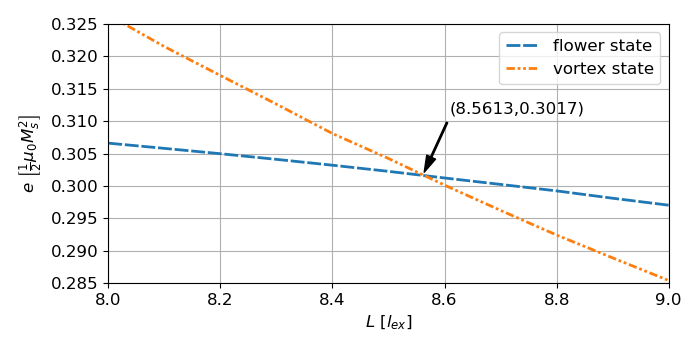

In [ ]:
from matplotlib.ticker import FormatStrFormatter


fig = plt.figure(figsize=(7,3.5))


ax = fig.subplots(1,1)
ax.plot(lam, _energies_flower["e_tot"], linestyle=(0, (5, 1)), linewidth=2, label="flower state")
ax.plot(lam, _energies_vortex["e_tot"], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2, label="vortex state")
ax.set_xlim((8., 9.))
ax.set_ylim((0.285, 0.325))
ax.legend()
ax.grid()
ax.set_xlabel("$L$ $\\left[l_{ex}\\right]$")
ax.set_ylabel("$e$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.tick_params(axis='both', which='major')

ax.annotate(f"({cross_section:.4f},{cross_section_energy:.4f})", xy=(cross_section,cross_section_energy),  xycoords='data',
            xytext=(0.85, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1,headwidth=7),
            horizontalalignment='right', verticalalignment='top', size=12
            )
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 9))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()

In [ ]:
_energies_flower

{'e_ani': Array([0.01441683, 0.01541906, 0.01646365, 0.01754696, 0.01866515,
        0.01981428, 0.02099032, 0.02218917, 0.02340679, 0.02463914,
        0.02588228], dtype=float32),
 'e_ex': Array([0.03593127, 0.03700234, 0.0381001 , 0.03921505, 0.04033834,
        0.04146172, 0.04257764, 0.04367919, 0.04476012, 0.04581485,
        0.04683841], dtype=float32),
 'e_mag': Array([0.2562753 , 0.25339657, 0.25042957, 0.24735951, 0.24421334,
        0.24099451, 0.23768222, 0.23438847, 0.23109007, 0.22766995,
        0.22432983], dtype=float32),
 'e_tot': Array([0.3066234 , 0.30581796, 0.30499333, 0.30412152, 0.30321681,
        0.30227053, 0.3012502 , 0.30025685, 0.29925698, 0.29812396,
        0.29705054], dtype=float32)}